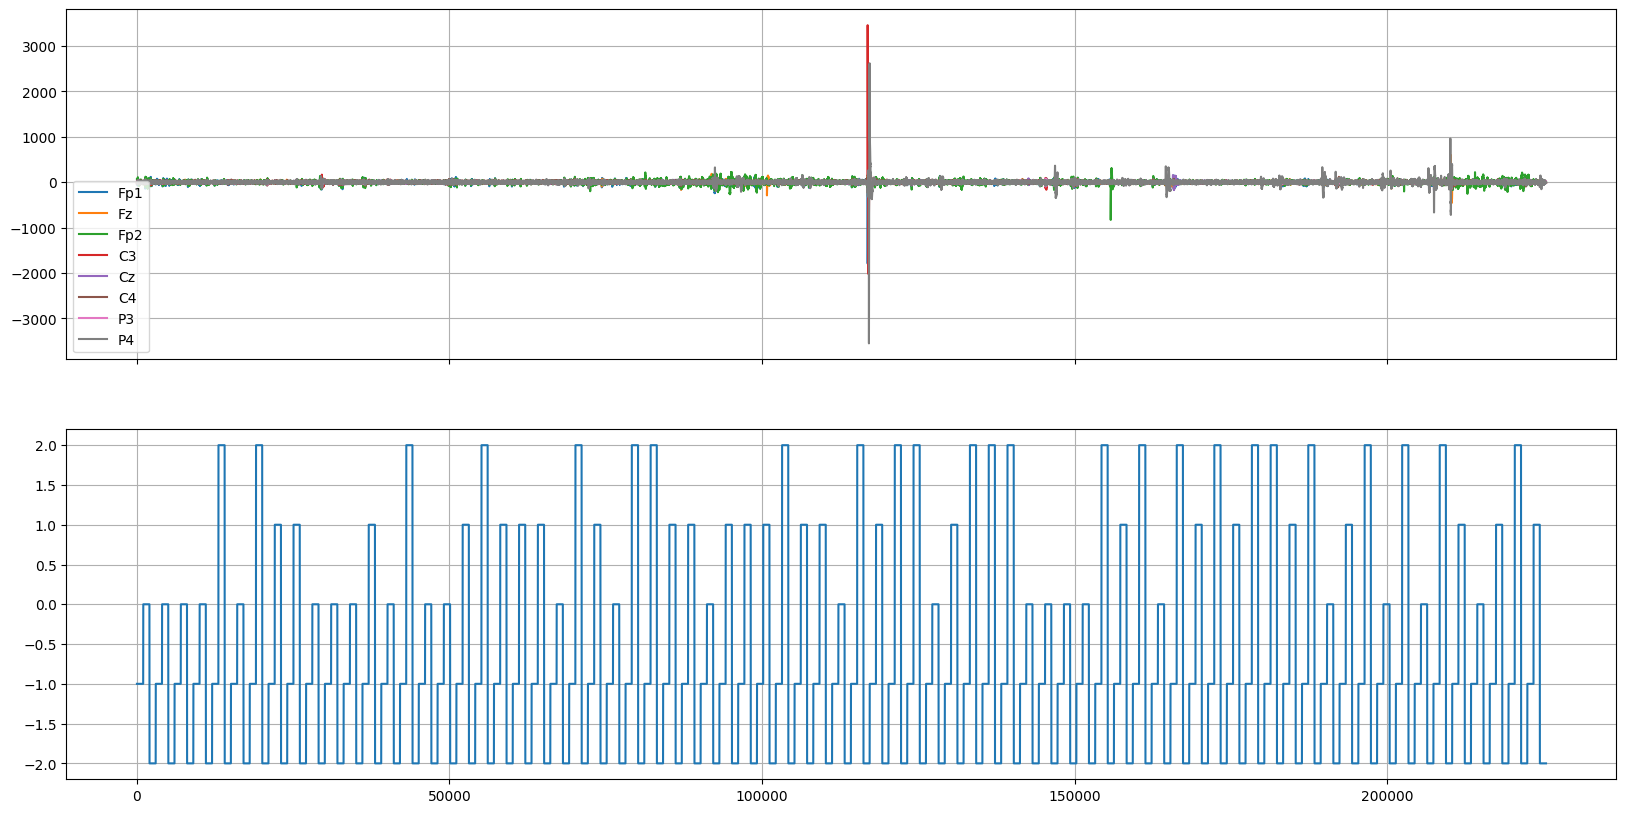

In [471]:
import matplotlib.pyplot as plt
import numpy as np

maps = {
    0:"Fp1", 1:"Fz", 2:"Fp2",
    3:"C3", 4:"Cz", 5:"C4",
    6:"P3", 7:"P4"
}

s = np.load("DemoData/signal_session_13.npy")
label = np.load("DemoData/label_session_13.npy").reshape(-1,1)
# times = np.load('timestamps_session_2.npy')
# times = times - times[0]

# t = np.linspace(0, times[-1], s.shape[0]) * 1e3
f, ax = plt.subplots(2,1, figsize=(20,10), sharex = True)
for i,n in enumerate(s.T):
    ax[0].plot(n, label = f"{maps[i]}")
ax[0].grid()
ax[0].legend()
ax[1].plot(label)
ax[1].grid()
plt.show()

# MNE Visualization

In [472]:
Xs = np.array([])
# for i in range(1,10 + 1):
temp_s = np.load("DemoData/signal_session_13.npy") * 1e-7
temp_l = np.load("DemoData/label_session_13.npy").reshape(-1,1)
temp_t = np.load("DemoData/timestamps_session_13.npy")
temp_t = (temp_t -temp_t[0])  * 10
timestamp = np.linspace(0, temp_t[-1], temp_l.shape[0])
classes = np.unique(temp_l)
timestamp.shape

(225430,)

Creating RawArray with float64 data, n_channels=8, n_times=225430
    Range : 0 ... 225429 =      0.000 ...   901.716 secs
Ready.


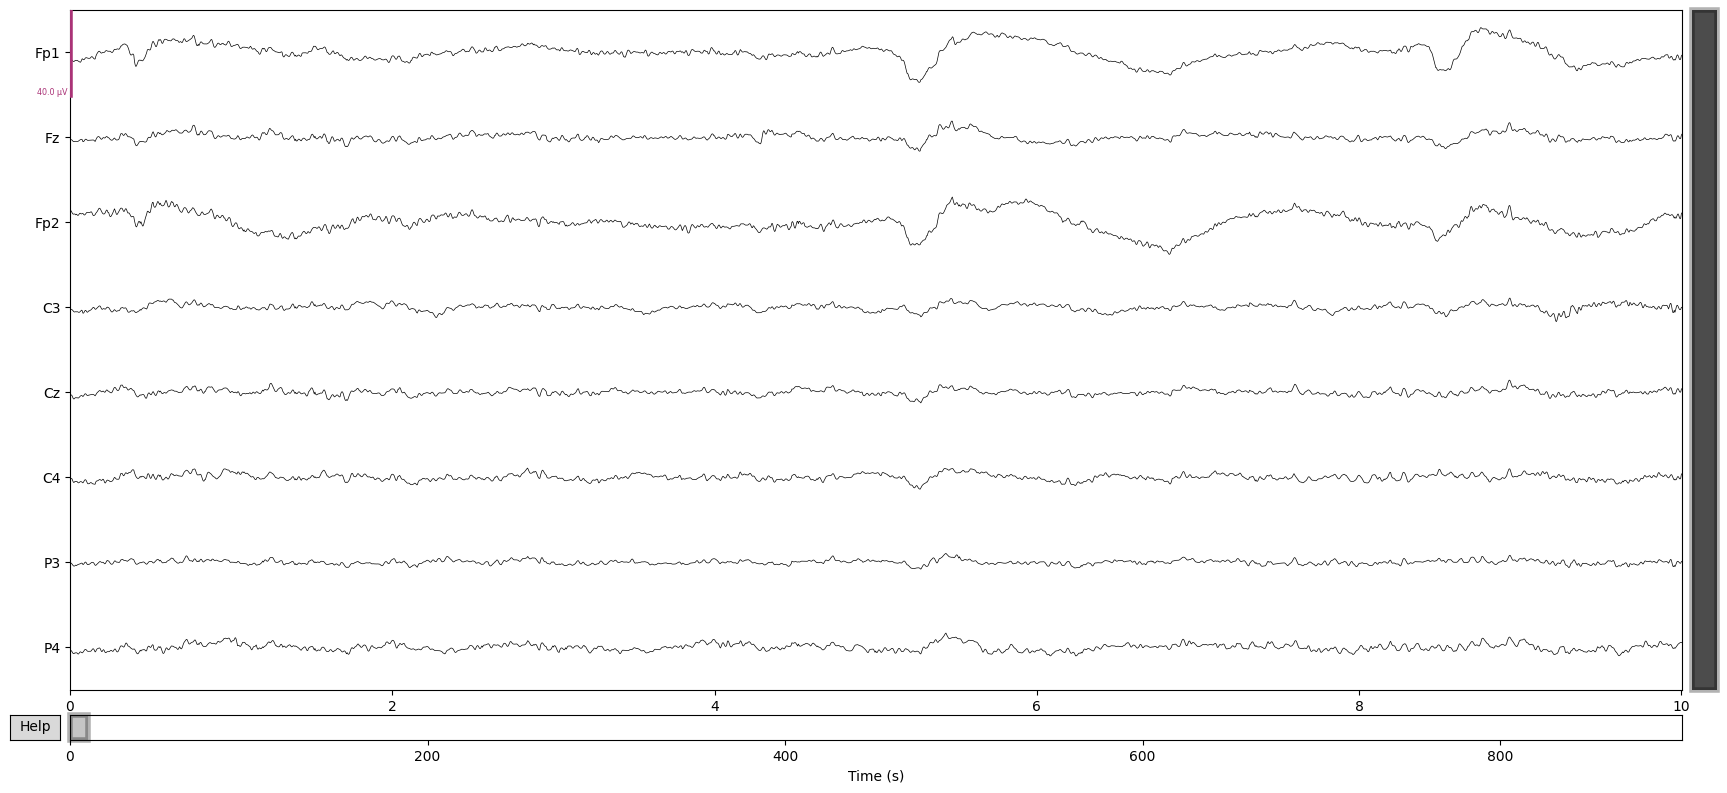

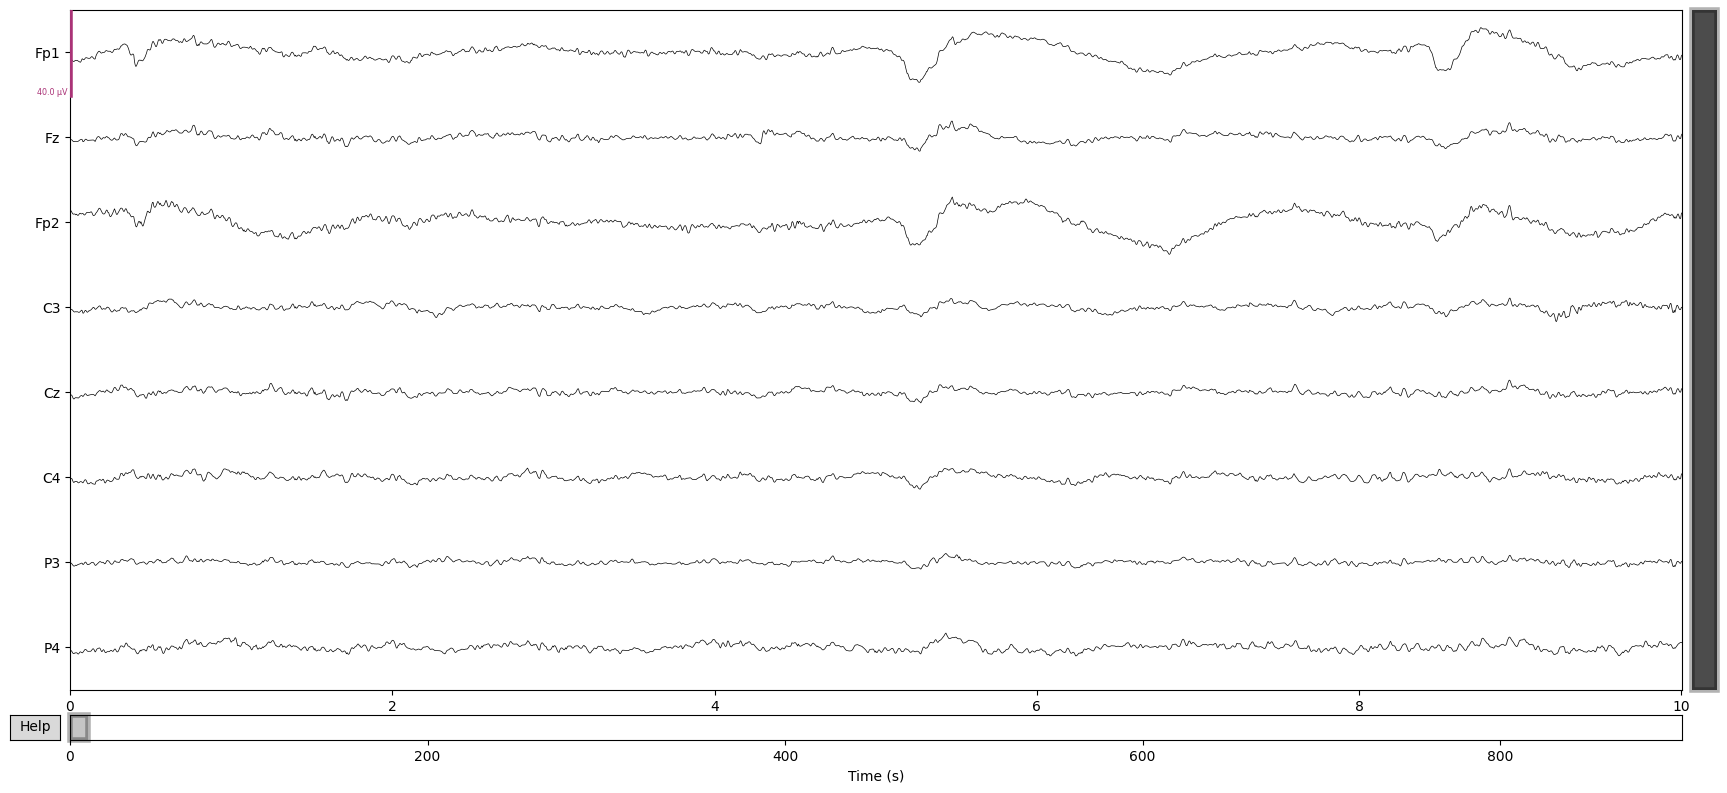

In [475]:
#create mne raw array
import mne
n_channels = 8
sfreq = 250
standard_1020_montage = mne.channels.make_standard_montage('standard_1020')
ch_names = ["Fp1", "Fz", "Fp2", "C3", "Cz", "C4", "P3", "P4"]
ch_types = ["eeg"] * len(ch_names)
# bads = ['Fp1']
bads = []

info = mne.create_info(sfreq=sfreq, ch_names=ch_names, ch_types=ch_types)
info['bads'] = bads
info['description'] = 'capilab dataset2 with openbci'
# info.set_meas_date("2023-11-01 16:29:01.881477") #session 11

# info.set_meas_date("2023-11-02 18:12:50.574316") #session 12
info.set_meas_date("2023-11-03 15:19:30.316758") #session 13
duration = np.linspace(0, temp_t[1], temp_s.shape[0])
raws = mne.io.RawArray(temp_s.T, info)
raws.set_montage(standard_1020_montage)
raws.plot()

In [476]:
sfreq = 250
event_loc = {
    0:[],1:[],2:[], -1:[], -2:[]
}
event_dict = {
    0:"idle", 1:"box", 2:"pen", -1:"stim_present", -2:"ready/cooldown"
}

onset = []
duration = []
description = []

#extract onset from label
for c in classes:
    loc = np.where(temp_l == c)[0]
    group_loc = np.split(loc, np.where(np.diff(loc) != 1)[0] + 1)
    for group in group_loc:
        event_loc[c].append((group[0], group[-1]))
#id, on_set, duration
for key, value in event_loc.items():
    for v in value:
        if key in [-2, -1]:
            continue
        onset.append(v[0]/ sfreq)
        duration.append((v[-1] - v[0]) / sfreq)
        description.append(event_dict[key])

annotation = mne.Annotations(
    onset = onset, duration = duration, description = description
)

raws.set_annotations(annotations=annotation)

<RawArray | 8 x 225430 (901.7 s), ~13.8 MB, data loaded>

#### Create epoch

In [477]:
#use the data from previoujs experiment, extract each epochs and arange it into (epoch x channel x time)
# create event
event = np.array([])
for key, value in event_loc.items():
    for v in value:
        if key in [-2, -1]:
            continue
        temp = np.array([v[0], 0, key])
        event = np.vstack([event, temp]) if event.size else temp

#parase raw to epoch
event_id = {v:k for k, v in event_dict.items() if k not in [-2, -1]}
tmin = -.5 #500ms before trigger
tmax = 3.5 #3.5s after trigger
picks = mne.pick_types(raws.info, eeg=True, stim = False, exclude=['bads'])
baseline = (None, 0)
epochs = mne.Epochs(raws, event, event_id, tmin, tmax, picks = picks, baseline=baseline, preload=True)

Not setting metadata
75 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 75 events and 1001 original time points ...
0 bad epochs dropped


C:\Users\capiAdmin\AppData\Local\Temp\ipykernel_17016\2185803985.py:17: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raws, event, event_id, tmin, tmax, picks = picks, baseline=baseline, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


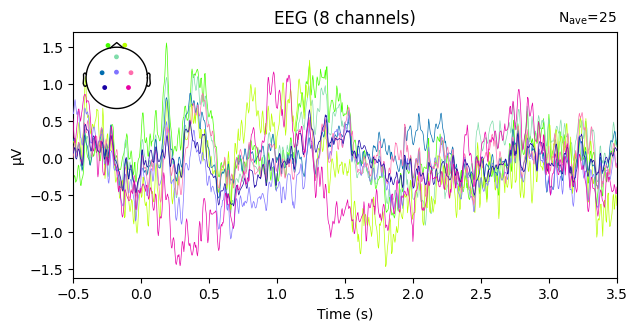

NOTE: plot_epochs_psd() is a legacy function. New code should use Epochs.compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\capiAdmin\anaconda3\envs\demo-eeg\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


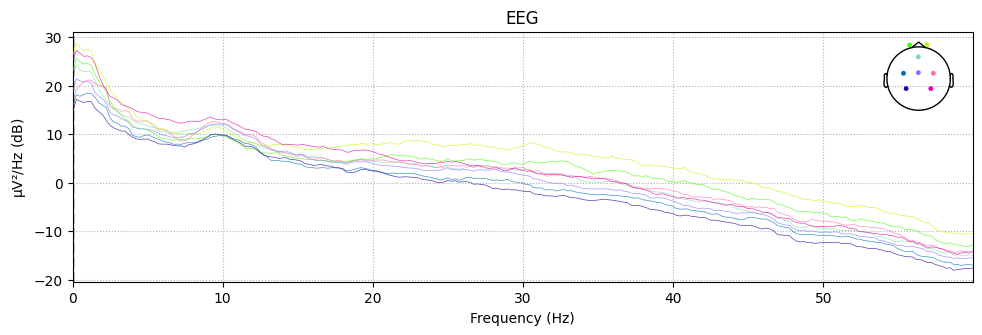

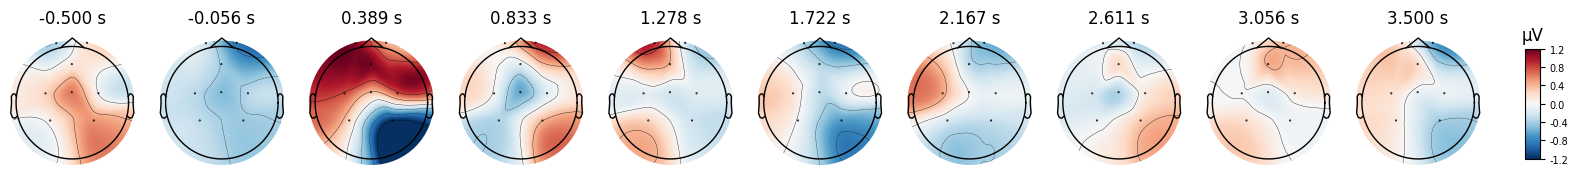

In [478]:
evoked_pen = epochs['pen'].average()
fig = evoked_pen.plot()
fig = mne.viz.plot_epochs_psd(epochs=epochs['pen'],fmax=60)
fig = evoked_pen.plot_topomap(times = np.linspace(-.5, 3.5, 10), ch_type='eeg')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


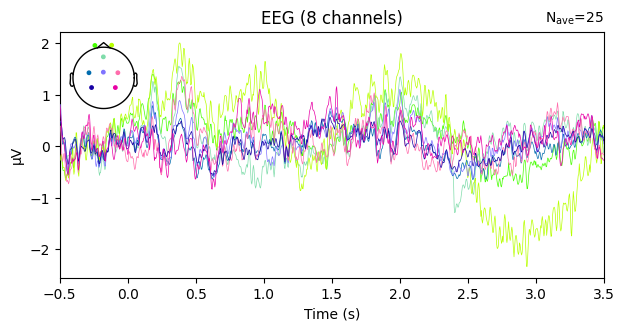

NOTE: plot_epochs_psd() is a legacy function. New code should use Epochs.compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\capiAdmin\anaconda3\envs\demo-eeg\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


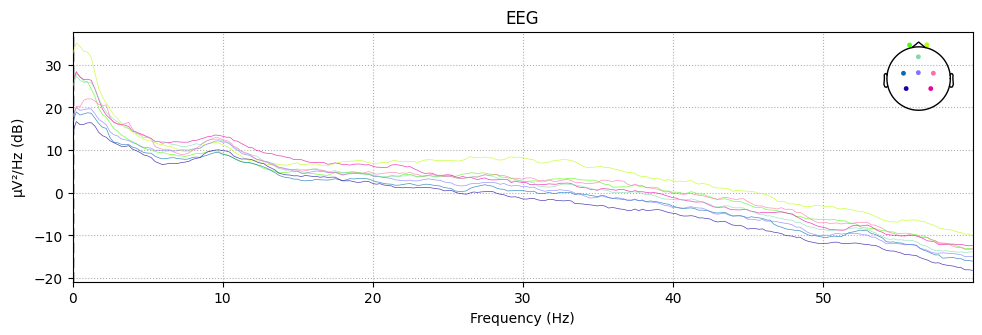

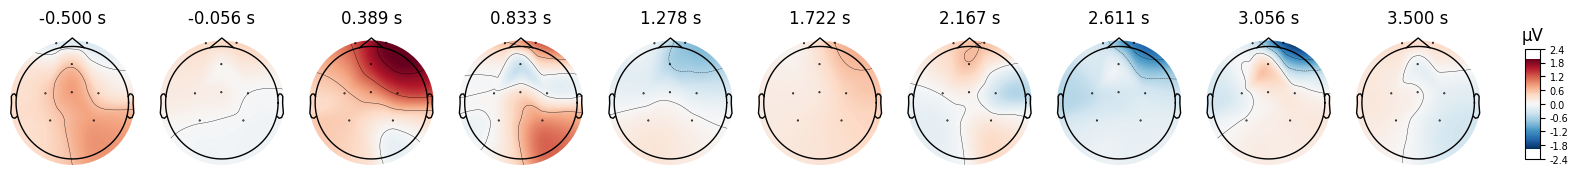

In [479]:
evoked_box = epochs['box'].average()
fig = evoked_box.plot()
fig = mne.viz.plot_epochs_psd(epochs=epochs['box'],fmax=60)
fig = evoked_box.plot_topomap(times = np.linspace(-.5, 3.5, 10), ch_type='eeg')


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


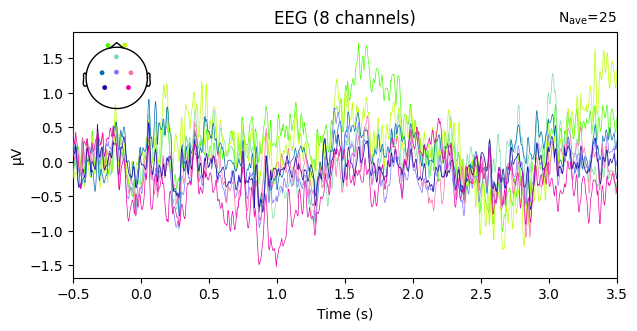

NOTE: plot_epochs_psd() is a legacy function. New code should use Epochs.compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\capiAdmin\anaconda3\envs\demo-eeg\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


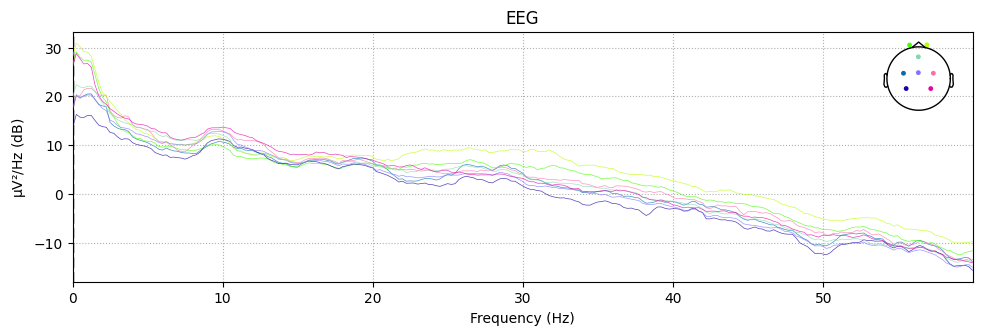

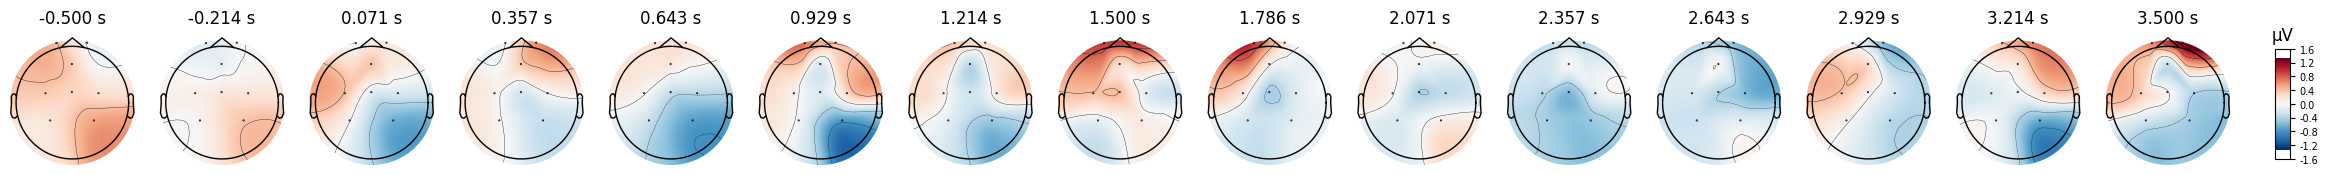

In [481]:
evoked_idle = epochs['idle'].average()
fig = evoked_idle.plot()
fig = mne.viz.plot_epochs_psd(epochs=epochs['idle'],fmax=60)
fig = evoked_idle.plot_topomap(times = np.linspace(-.5, 3.5, 15), ch_type='eeg')

In [482]:
idle_epochs = epochs['idle'].pick('eeg').get_data()
box_epochs = epochs['box'].pick('eeg').get_data()
pen_epochs = epochs['pen'].pick('eeg').get_data()

np.save("idle3", idle_epochs)
np.save("box3", box_epochs)
np.save("pen3", pen_epochs)